In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import math
import torch.multiprocessing as mp
from transformers import BertTokenizerFast
import pickle
import os
import json
import util
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
detokenize = tokenizer.convert_ids_to_tokens
batch_detokenize = tokenizer.batch_decode
device = 'cuda'
image_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Dùng cho ImageNet
])

In [2]:
class EncoderCNN(nn.Module):
    def __init__(self, output_size: int):
        super(EncoderCNN, self).__init__()
        self.inception_model = models.inception_v3(pretrained=True)
        #self.inception_model.fc = torch.nn.Identity()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1000, output_size)
        for name, param in self.inception_model.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
    def forward(self, images: torch.Tensor):
        features = self.inception_model(images) #[1, 2048]
        if isinstance(features, tuple):  # Nếu là tuple
            features = features[0] 
        features = self.relu(features)
        features = self.dropout(features)
        features = self.fc(features)
        return features
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, input_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    def forward(self, features: torch.Tensor, captions: torch.Tensor, hidden_state: tuple[torch.Tensor, torch.Tensor] = None): 
        # Constant : seq = 1
        # features : [bsz, img_sz]
        # captions : [bsz, seq]
        # hidden : [num_layers, bsz, hidden]
        embeddings = self.embed(captions) # [bsz, seq, embed]
        features = features.unsqueeze(1).expand(-1, embeddings.shape[1], -1) # [bsz, seq, embed]
        combined = torch.cat((features, embeddings), dim=2) # [bsz, seq, img_sz + embed]
        if hidden_state == None:
            hidden_state = (
                torch.zeros(self.num_layers, captions.shape[0], self.hidden_size).to(captions.device),
                torch.zeros(self.num_layers, captions.shape[0], self.hidden_size).to(captions.device)
            )
            # hidden_state : [num_layers, seq, hid] * 2
        output, hidden_state = self.lstm(combined, hidden_state)
        # output : [bsz, seq, vocab_size]
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear(output)
        return output, hidden_state
class ImageToTextModel(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super(ImageToTextModel, self).__init__()
        self.encoder: EncoderCNN = encoder
        self.decoder: DecoderRNN = decoder
    def forward(self, images: torch.Tensor, captions: torch.Tensor):
        # Constant : SEQ_LENGTH = 46, seq = 1
        # images: [bsz, 3, raw_image_width, raw_image_height]
        # captions: [bsz, SEQ_LENGTH]
        bsz = images.shape[0]
        hidden_state: tuple[torch.Tensor, torch.Tensor] = None
        features = self.encoder(images)
        # features: [bsz, img_sz]
        seq_predicted = []
        seq_predicted.append(torch.zeros((bsz, self.decoder.vocab_size), dtype=torch.float32).unsqueeze(1).to(device))
        # seq_predicted : [predict_length, seq, vocab]
        decoder_input = captions[:, 0].unsqueeze(1)
        # decoder_input : [bsz, seq]
        seq_length = captions.shape[1]
        for di in range(1, seq_length):
            output_decoder, hidden_state = self.decoder(features, decoder_input, hidden_state)
            # ouput_decoder: [bsz, seq, vocab]
            # hidden_state: [num_layers, bsz, hidden_size] * 2
            decoder_input = captions[:, di].unsqueeze(1)
            # decoder_input : [bsz, seq]
            seq_predicted.append(output_decoder)
        return torch.cat(seq_predicted, dim=1)
    def predict(self, images: torch.Tensor, captions: torch.Tensor, predict_length: int):
        bsz = images.shape[0]
        hidden_state: tuple[torch.Tensor, torch.Tensor] = None
        features = self.encoder(images)
        seq_predicted = []
        seq_predicted.append(torch.zeros((bsz, self.decoder.vocab_size), dtype=torch.float32).unsqueeze(1).to(device))
        decoder_input = captions[:, 0].unsqueeze(1)
        seq_length = captions.shape[1]
        for di in range(1, seq_length):
            output_decoder, hidden_state = self.decoder(features, decoder_input, hidden_state)
            decoder_input = captions[:, di].unsqueeze(1)
        for di in range(1, predict_length):
            output_decoder, hidden_state = self.decoder(features, decoder_input, hidden_state)
            seq_predicted.append(output_decoder)
            decoder_input = output_decoder.argmax(2)
        return torch.cat(seq_predicted, dim=1)


In [3]:
def plotter(train_log: list[dict[str, object]]) :
    train_loss = []
    test_loss = []
    lr = []
    accuracy = []
    bleu_1 = []
    bleu_2 = []
    bleu_3 = []
    bleu_4 = []
    for train_log_ in train_log:
        train_loss.append(train_log_.get("Train loss", 0))
        test_loss.append(train_log_.get("Test loss", 0))
        lr.append(train_log_.get("Learning rate"))
        metrics: dict[str, object] = train_log_["Metrics"]
        accuracy.append(metrics.get("accuracy"))
        bleu_1.append(metrics.get("bleu_1"))
        bleu_2.append(metrics.get("bleu_2"))
        bleu_3.append(metrics.get("bleu_4"))
        bleu_4.append(metrics.get("bleu_4"))
    plt.figure(figsize=(5,3))
    plt.plot(train_loss, label = "Train loss", color = "blue")
    plt.plot(test_loss, label = "Test loss", color = "red")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(accuracy, label= "Test accuracy", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(lr, label= "Learning rate", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(bleu_1, label= "BLEU-1", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(bleu_2, label= "BLEU-2", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(bleu_3, label= "BLEU-3", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(bleu_4, label= "BLEU-4", color = "blue")
    plt.legend()

In [4]:
TIME_STAMP = "2024-12-11_19-21-10"
CHECKPOINT_FOLDER = os.path.join("checkpoint/teset_model", TIME_STAMP)

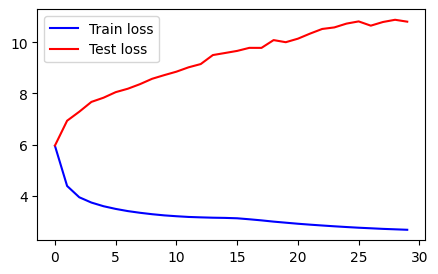

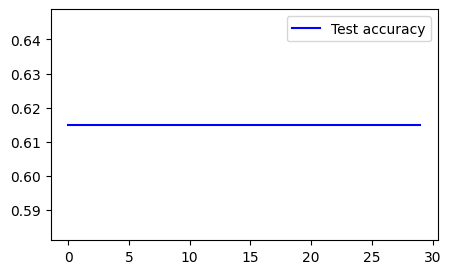

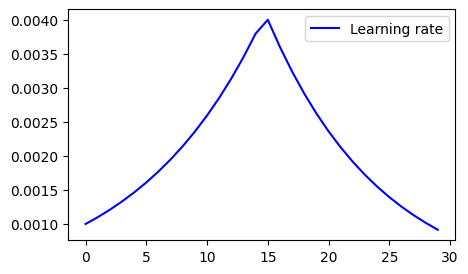

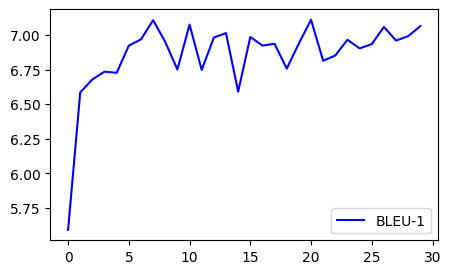

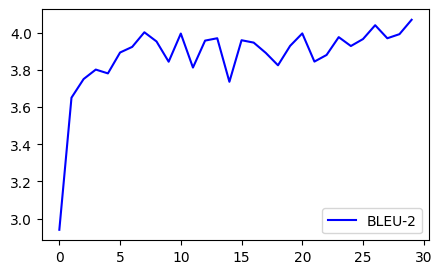

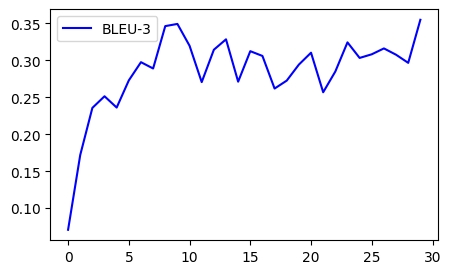

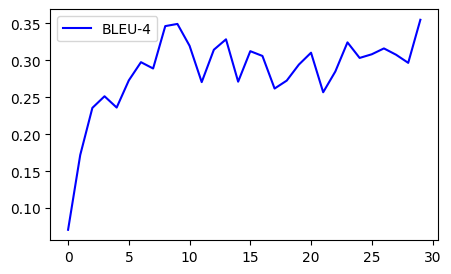

In [ ]:
with open(os.path.join(CHECKPOINT_FOLDER, "logs.json"), 'r') as file:
    logs = json.loads(file.read())
# plotter(logs)

In [6]:
model: ImageToTextModel = util.load_model_chunks(
    folder_path=CHECKPOINT_FOLDER,
    name="model"
)

d:\Programming\Storage\Class\2024-2025\DeepLearning\Image-description\Fine_Tune\util\multi_part_model_serialize.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = 

In [21]:
from PIL import Image
SEQ_LENGTH = 46
def interactive_test(
        itt: ImageToTextModel,
        image_path: str,
        text: str,
        predict_length: int
    ):
    tokens: list[int] = tokenizer.encode(text)
    tokens.pop(-1)
    # while(len(tokens) < SEQ_LENGTH):
    #     tokens = [0] + tokens
    tokens: torch.Tensor = torch.tensor(tokens)
    images = torch.Tensor(image_transforms(Image.open(image_path).convert("RGB")))
    images = images.unsqueeze(0)
    tokens = tokens.unsqueeze(0)
    itt.eval()
    images: torch.Tensor = images.to(device)
    tokens: torch.Tensor = tokens.to(device)
    output = itt.predict(images, tokens, predict_length)
    target_logits = output[:, -1, :]
    predicts = output.argmax(2)
    predicted_token = target_logits.argmax()
    # predicted_token = ""
    return predicted_token, tokens, predicts

image_ids = [
    "1386964743_9e80d96b05.jpg",
    "99679241_adc853a5c0.jpg",
    "802594049_289e3c8420.jpg",
    "110595925_f3395c8bd6.jpg",
    "667626_18933d713e.jpg"
]
image_id = image_ids[0]
image_path = f"../Flickr8k/Flicker8k_Dataset/{image_id}"
text = ""
model.to(device)
predict_token, caption, predict = interactive_test(
    model, image_path, text,
    predict_length=15
)
# print(predicts, captions)
predict_token = predict_token.item()
predict = predict[0]
caption = caption[0]
# print(predicts)
# print(captions)
# print(detokenize(predict_token))
print(detokenize(predict))
print(detokenize(caption))


# for i in range(min(len(predicts), captions.shape[0])):
#     print(detokenize(predicts[i]), detokenize(captions[i].item()))

['[PAD]', 'a', 'dog', 'is', 'running', 'through', 'a', 'field', 'of', 'grass', '.', '[SEP]', '.', '[SEP]', '.']
['[CLS]']
